In [1]:
#import modul
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API 
from tweepy import Cursor
from tweepy import Stream
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [2]:
# Akses key token dan consumer key token untuk menghubungkan twitter dengan jupyter lab
ACCESS_TOKEN = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
ACCESS_TOKEN_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
CONSUMER_KEY = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
CONSUMER_SECRET = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"

In [3]:
# Client Twitter
class TwitterClient():
    def __init__(self, user_twitter=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)

        self.user_twitter = user_twitter

    def get_twitter_client_api(self):
        return self.twitter_client

    def get_user_timeline_tweets(self, num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id=self.user_twitter).items(num_tweets):
            tweets.append(tweet)
        return tweets

    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends, id=self.user_twitter).items(num_friends):
            friend_list.append(friend)
        return friend_list

    def get_home_timeline_tweets(self, num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline, id=self.user_twitter).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets

In [4]:
#Autentifikasi twitter
class TwitterAuthenticator():

    def authenticate_twitter_app(self):
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        return auth

In [5]:
#Stream Twitter
class TwitterStreamer():
    """
    Class untuk streaming dan pemrosesan tweet langsung.
    """
    def __init__(self):
        pass

    def stream_tweets(self, fetched_tweets_filename, hash_tag_list):
        #Autentifikasi twitter dan koneksi ke twitter streaming API
        listener = StdOutListener(fetched_tweets_filename)
        auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
        auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
        stream = Stream(auth, listener)

        # Untuk memfilter streaming twitter dengan hastag atau kata kunci
        stream.filter(track=hash_tag_list)

In [6]:
# Twitter Stream Listener
class TwitterListener(StreamListener):
    """
    Basic listener untuk menampilkan tweets
    """
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename

    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print("Error on_data %s" % str(e))
        return True
          
    def on_error(self, status):
        if status == 420:
            return False
        print(status)

#analisis twitter 
class TweetAnalyzer():
    """
    Fungsi untuk menganalisis tweet dan mengkategorikan konten-konten dari twitter
    """
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

    #Analisis sentimen dengan polarity dan text blob
    def analyze_sentiment(self, tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    
    #Menampilkan hasil kedalam sebuah tabel
    def tweets_to_data_frame(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=["tweets"])
        df["No"] = np.arange(start = 1, stop = len(df)+1)
        df["Id"] = np.array([tweet.id for tweet in tweets])
        df["Date"] = np.array([tweet.created_at for tweet in tweets])
        df["Likes"] = np.array([tweet.favorite_count for tweet in tweets])
        df["Retweets"] = np.array([tweet.retweet_count for tweet in tweets])
        df = df[["No", "tweets", "Id", "Date", "Likes", "Retweets"]]
        return df

 
if __name__ == '__main__':

    twitter_client = TwitterClient()
    tweet_analyzer = TweetAnalyzer()

    api = twitter_client.get_twitter_client_api()
    
    #akun yang akan dilakukan analisis sentiment adalah akun @awscloud dengan jumlah sampel tweet yg diambil 200
    tweets = api.user_timeline(screen_name="awscloud", count=200)

    df = tweet_analyzer.tweets_to_data_frame(tweets)
    df["sentiment"] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df["tweets"]])

In [7]:
df.head()

,No,tweets,Id,Date,Likes,Retweets,sentiment
0,1,Would you throw if you knew the receiver only ...,1173023724251095040,2019-09-15 00:00:24,22,8,1
1,2,#MachineLearning tips &amp; tricks: Learn how ...,1172990205818744840,2019-09-14 21:47:12,28,7,0
2,3,"Are you familiar with AWS Lambda, where you ca...",1172934037826150401,2019-09-14 18:04:01,73,20,1
3,4,Gartner’s perspective in this new article 📰 sh...,1172926992741752832,2019-09-14 17:36:01,31,12,1
4,5,Find out how to stream live video from devices...,1172916422504321024,2019-09-14 16:54:01,35,14,1


In [8]:
#nama kolom 
df.columns

Index(['No', 'tweets', 'Id', 'Date', 'Likes', 'Retweets', 'sentiment'], dtype='object')

In [9]:
#menghitung jumlah sentimen positif, negatif dan netral
positive_count = df[df.sentiment == 1].count()
neutral_count = df[df.sentiment == 0].count()
negative_count = df[df.sentiment == -1].count()
print("Positif: ",positive_count["sentiment"])
print("Negatif: ",negative_count["sentiment"])
print("netral: ", neutral_count["sentiment"])

Positif:  103
Negatif:  15
netral:  82


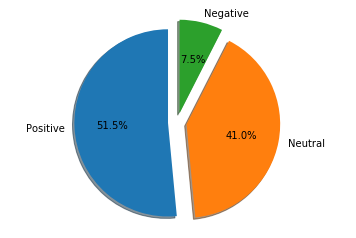

In [10]:
# Visualisasi hasil sentimen analisis dengan diagram pie
labels = 'Positive', 'Neutral', 'Negative'
sizes = [positive_count["sentiment"], neutral_count["sentiment"], negative_count["sentiment"]]
explode = (0.1, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()